# Evaluation of radial distortion with triangulation

**Author:** Yannick Copin <y.copin@ipnl.in2p3.fr>

**Abstract:** The radial distortion tends to alter more the positions in the outer part of the field, while it has little impact close to the center of distortion. Triangulation of distorted positions generated from a regular grid can be used to estimate the center of distortion, as well as undistorted step and rotation angle. 

In [1]:
import numpy as N
import scipy as S
import matplotlib.pyplot as P
%matplotlib inline

## Create a distorted grid 

In [2]:
def create_grid(nx, ny, scale=1., rotation=0.):
    """Create a (npts, 2) array of coordinates."""
    
    x = N.arange(nx) - (nx-1)/2.
    y = N.arange(ny) - (ny-1)/2.
    xy = N.array(N.meshgrid(x, y)).T.reshape(-1, 2).astype(float)  # npts × [x, y]
    xy *= scale
    if rotation:
        # Convert to complex and rotate
        xy = (xy[:, 0] + 1j * xy[:, 1]) * N.exp(1j*rotation)
        xy = N.vstack((xy.real, xy.imag)).T  # npts × [x, y]
    
    return xy

Undistorted positions:

In [3]:
nx, ny = 20, 15
scale = 2
rotation = N.deg2rad(5.)

_xy = create_grid(nx, ny, scale=scale, rotation=rotation)  # Undistorted positions npts × [x, y]
print "Nb of points:", len(_xy)

Nb of points: 300


Add r² radial distortion:

In [4]:
xy0 = [3, 5]  # True center of distortion
K1 = 0.005  # Radial distortion r²-coeff
r2 = N.sum((_xy - xy0)**2, axis=1)
t = N.arctan2(_xy[:, 1], _xy[:, 0])
xy = _xy + K1 * N.vstack((r2 * N.cos(t), r2 * N.sin(t))).T  # Distorted positions

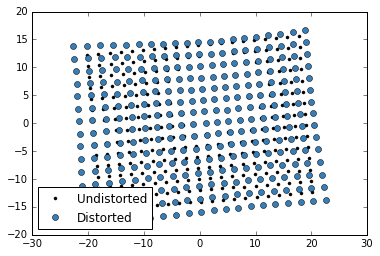

In [5]:
P.plot(_xy[:, 0], _xy[:, 1], '.k', label='Undistorted')
P.plot(xy[:, 0], xy[:, 1], 'o', label='Distorted')
P.legend(loc='lower left', numpoints=1)

## Triangulation

### Using `scipy.spatial.Delaunay`

In [6]:
from scipy.spatial import Delaunay, delaunay_plot_2d
tess = Delaunay(xy)

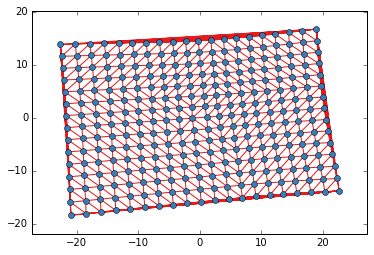

In [7]:
fig = delaunay_plot_2d(tess)  # plot + triplot

[`scipy.spatial.Delaunay`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html) lacks of helper methods/functions to post-process the triangulation. We rather use [`matplotlib.tri.Triangulation`](http://matplotlib.org/api/tri_api.html#matplotlib.tri.Triangulation).

### Using `matplotlib.tri.Triangulation`

In [8]:
tri = P.matplotlib.tri.Triangulation(xy[:, 0], xy[:, 1])

Remove quasi-degenerate triangles on the borders:

In [9]:
# See http://matplotlib.org/mpl_examples/pylab_examples/tricontour_smooth_delaunay.py
min_circle_ratio = 0.1
mask = P.matplotlib.tri.TriAnalyzer(tri).get_flat_tri_mask(min_circle_ratio)
tri.set_mask(mask)
print("After selection: {} triangles, {} edges".format(tri.triangles.shape[0], tri.edges.shape[0]))

After selection: 594 triangles, 831 edges


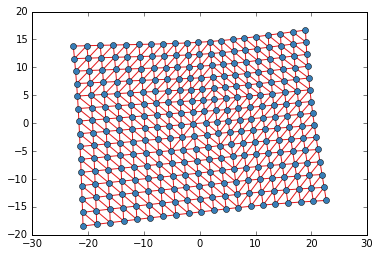

In [10]:
P.plot(xy[:, 0], xy[:, 1], 'o')
P.triplot(tri);

## Triangulation analysis

Compute length of all (selected) edges:

In [11]:
edges = xy[tri.edges]  # nedges × [start, end] × [x, y]
dxy = edges[:, 1] - edges[:, 0]  # nedges × [x, y]
lengths = N.sum(dxy**2, axis=1)**0.5  # nedges

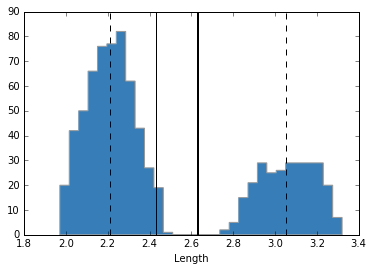

In [12]:
P.hist(lengths, bins=30, histtype='stepfilled')

cut = N.percentile(lengths, 66)
P.axvline(cut, c='k')
medinf = N.median(lengths[lengths <= cut])
medsup = N.median(lengths[lengths >= cut])
P.axvline(medinf, c='k', ls='--')
P.axvline(medsup, c='k', ls='--')
med = (medinf + medsup) / 2
P.axvline(med, c='k', lw=2)
P.xlabel("Length");

Normalized lengths:

In [13]:
diags = lengths > med  # Diagonals
lengths[diags] /= 2**0.5

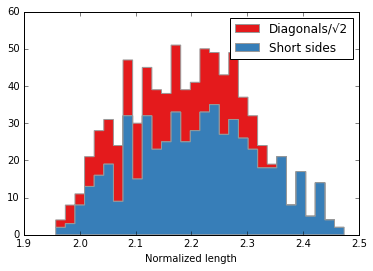

In [14]:
P.hist([lengths[~diags], lengths[diags]], bins=30, stacked=True, histtype='stepfilled',
       label=['Short sides', u'Diagonals/√2'])
P.legend(loc='upper right')
P.xlabel("Normalized length");

Compute angles (modulo π/4):

In [15]:
angles = N.rad2deg(N.arctan2(dxy[:, 1], dxy[:, 0])) + 180.
angles = (4 * angles - 180 * N.around(4*angles/180)) / 4

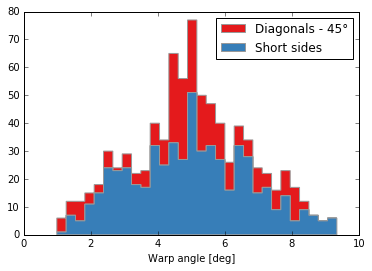

In [16]:
P.hist([angles[~diags], angles[diags]], bins=30, stacked=True, histtype='stepfilled',
       label=['Short sides', u'Diagonals - 45°'])
P.legend(loc='upper right')
P.xlabel("Warp angle [deg]");

Sort edges by increasing length:

In [17]:
iedges = N.argsort(lengths)

Compute elements of distortions from smallest edges:

In [18]:
frac_cen = 0.05
ncen = int(len(edges) * frac_cen)
print "Nb of undistorted edges:", ncen
shortests = edges[iedges[:ncen]]   # ncen × [start, end] × [x, y]
xyc = N.mean(shortests, axis=(0, 1))  # Center of distortion
print "Center of distortion:", xyc
length = N.median(lengths[iedges[:ncen]])  # Undistorted step
print "Undistorted step:", length
angle = N.median(angles[iedges[:ncen]])  # Undistorted angle
print "Undistorted angle [deg]:", angle

Nb of undistorted edges: 41
Center of distortion: [ 2.86707356  4.30324354]
Undistorted step: 2.00605382314
Undistorted angle [deg]: 5.03934704597


## Reference grid

Modeled positions (undistorted):

In [19]:
xyu = create_grid(nx, ny, scale=length, rotation=N.deg2rad(angle))  # Modeled (undistorted) positions

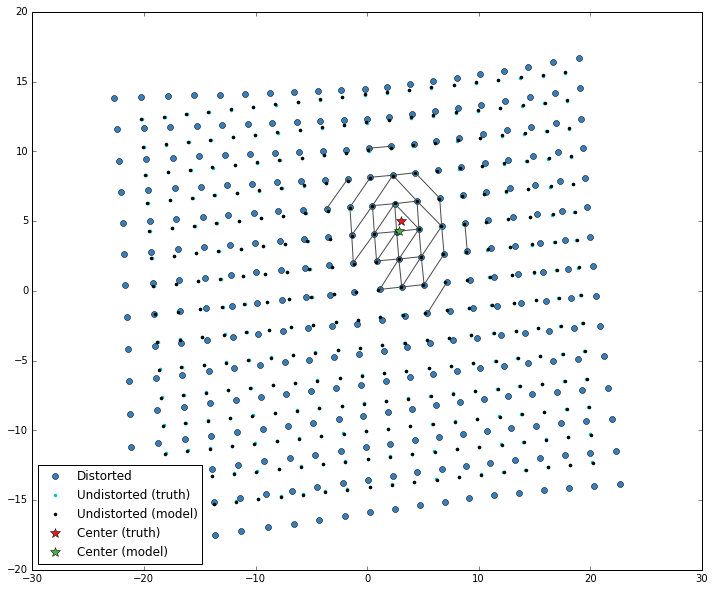

In [20]:
P.plot(xy[:, 0], xy[:, 1], 'o', label='Distorted')
P.plot(shortests[..., 0].T, shortests[..., 1].T, c='0.3')
P.plot(_xy[:, 0], _xy[:, 1], '.c', label='Undistorted (truth)')
P.plot(xyu[:, 0], xyu[:, 1], '.k', label='Undistorted (model)')
P.plot([xy0[0]], [xy0[1]], marker='*', ms=10, ls='none', label='Center (truth)')
P.plot([xyc[0]], [xyc[1]], marker='*', ms=10, ls='none', label='Center (model)')
P.legend(loc='lower left', numpoints=1)
P.gcf().set_size_inches((12, 10))

Radial distortion:

In [21]:
ru = N.sum((_xy - xyc)**2, axis=1)**0.5
offsets = xy - xyu  # npts × [x, y]
dr = N.hypot(offsets[:, 0], offsets[:, 1])

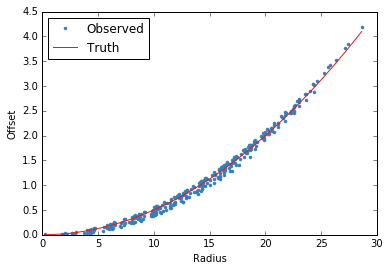

In [22]:
P.plot(ru, dr, '.', label='Observed')
sru = N.sort(ru)
P.plot(sru, K1 * sru**2, marker='', ls='-', label='Truth')
P.xlabel("Radius")
P.ylabel("Offset")
P.legend(loc='upper left', numpoints=1);

## `spectrogrism.distortion` implementation

The aforementioned procedure is implemented in the `spectrogrism.distortion` module. The rescaling of long edges is not trustworthy, and is not applied.

In [23]:
from spectrogrism import distortion as SD

Structured grid: 15 x 15 = 225 positions
Geometric distortion: center=(+3, +4), K-coeffs=[ 0.001], P-coeffs=[ 0.001  0.     0.001]


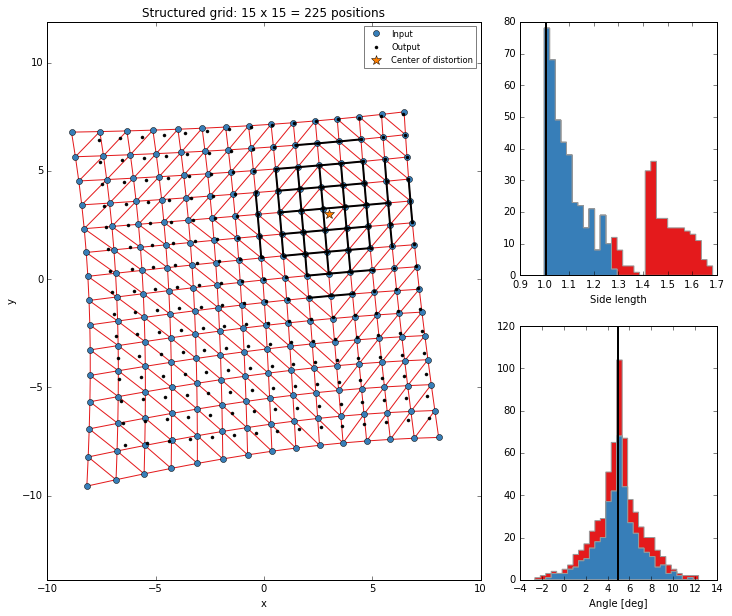

In [24]:
grid = SD.StructuredGrid.create(15, 15, scale=1, rotation=N.deg2rad(5.))
print(grid)

# Add distortions
gdist = SD.GeometricDistortion(3 + 4j,
                               Kcoeffs=[1e-3], Pcoeffs=[1e-3, 0, 1e-3])
print(gdist)

grid.xy = gdist.forward(grid.xy)

fig = P.figure()
length, angle, offset, center = grid.model_parameters(fig=fig)
fig.set_size_inches((12, 10))